# Intriduction to hyperparameters optimization with *hyperopt* and ReservoirPy

In [1]:
import json

import requests
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

from reservoirpy import ESN, mat_gen
from reservoirpy.hyper import research, plot_hyperopt_report

## Example 1: Double-scroll attractor

The double-scroll attractor or Chua's attractor is defined be the following differential equations:

$$
\begin{aligned}
\frac{dx}{dt} &= a(y(t) - x(t)) \\
\frac{dy}{dt} &= (c - a)x(t) - x(t)z(t) + cy(t) \\
\frac{dz}{dt} &= x(t)y(t) - bz(t)
\end{aligned}
$$

These equations describes a kind of electrical devices, which are known to have a chaotic behaviour.

In [2]:
from reservoirpy.datasets import multiscroll

timesteps = 10000
X = multiscroll(timesteps)

# rescale between -1 and 1
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

In [5]:
def plot_multiscroll(X, sample=2000):
    
    t = np.arange(X.shape[0])
    fig = plt.figure(figsize=(13, 5))
    plt.margins(0.05)

    plt.subplot(121)
    plt.plot(t[:sample], X[:sample, 0], color="lightgray", zorder=0)
    plt.scatter(t[:sample], X[:sample, 0], cmap="viridis", c=t[:sample], s=0.5)
    plt.xlabel("$t$")
    plt.ylabel("$P(t)$")
    plt.title("Multiscroll attractor")

    cbar = plt.colorbar()
    cbar.ax.set_xlabel('$t$')

    ax = plt.subplot(122, projection="3d")
    plt.plot(X[:sample, 0], X[:sample, 1], X[:sample, 2], color="lightgray", zorder=0, lw=0.5)
    plt.scatter(X[:sample, 0], X[:sample, 1], zs=X[:sample, 2], cmap="viridis", c=t[:sample], s=0.8)
    plt.title("Phase diagram")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    ax.set_zlabel("$z$")

    plt.tight_layout()
    plt.show()

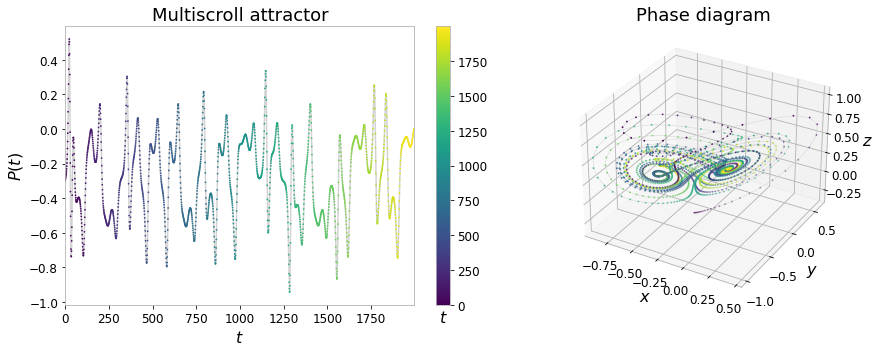

In [6]:
plot_multiscroll(X)

### Step 1: define the objective

The first steps consists in defining the objective function you want to optimize. This is the most important step: you must define an experimentation which is reproducible and which will produce results that can be measured to approximate the function you want to optimize.

Most optimization algorithms relies on the hypothesis of *convexity* (like most estimators in machine learning). In our case, that means that *hyperopt* expects that the objective function have at least some local minima that can be reached by shifting the parameters.

We therefore chose $RMSE$ (Root Mean Squared Error) as a *loss function*, the function that will be used within the objective function to evaluate the quality of the parameters we chose. We can make the assumption that this function, combined with the model function of the ESN, has a least some local minima without taking to much risks. Of course, we do not know the shape of this function, and we can't "plot it" to see where the minimum is. This is why we will rely on tools like *hyperopt* to approximate this function in many points, and empirically find a minimum.

In addition to the loss function, we also compute an other metric, the $R^2$.

In [7]:
def r2_score(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - y_true.mean())**2))

def rmse(y_true, y_pred):
    return np.sqrt((np.sum(y_true - y_pred)**2) / len(y_true))

In [8]:
# objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict.
def objective(dataset, config, *, iss, N, sr, leak, ridge, seed):
        
    # unpack train and test data, with target values.
    # data will be splitted in two folds.
    num_folds = 2
    
    train_data, test_data = dataset
    (X_train, y_train), (X_train2, y_train2) = train_data # fold 1
    (X_test, y_test), (X_test2, y_test2) = test_data # fold 2
    
    X_trains = X_train, X_train2
    X_tests = X_test, X_test2
    y_trains = y_train, y_train2
    y_tests = y_test, y_test2

    nb_features = X_train.shape[1]

    instances = config["instances_per_trial"]

    variable_seed = seed # the seed will be changed across the instances, always in the 
                         # way across the trials, to be sure there is no bias in the results
                         # due to initialization.
    
    losses = []; r2 = [];
    for n in range(instances):
        for i in range(num_folds):
            # builds an ESN given the input parameters
            W = mat_gen.fast_spectral_initialization(N=N, sr=sr,
                                                     seed=variable_seed)

            Win = mat_gen.generate_input_weights(nbr_neuron=N, dim_input=nb_features, 
                                                 input_bias=True, input_scaling=iss,
                                                 seed=variable_seed+1)


            reservoir = ESN(lr=leak, W=W, Win=Win, input_bias=True, ridge=ridge)


            # train and test the model
            reservoir.train([X_trains[i]], [y_trains[i]], verbose=False)
        
            seed_timesteps = 100
            warming_inputs = X_tests[i][:seed_timesteps]
            generations = X_tests[i].shape[0] - seed_timesteps
            outputs, _, _, _ = reservoir.generate(generations, warming_inputs=warming_inputs, verbose=False)

            losses.append(rmse(outputs[0], y_tests[i][:seed_timesteps]))
            r2.append(r2_score(outputs[0], y_tests[i][:seed_timesteps]))
        
        variable_seed += 1 # shift the seed between instances

    # returns a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2)}

### Step 2: define the research space

We can now define how we want hyperopt to find a minimum of the loss function, and what parameters we want to optimize.

Hyperopt configuration files can be written as shown in the next cell. The "exp", "hp_max_evals", "hp_method" and "hp_space" are mandatory. All the other keys are optionnal, like "seed", or are user-defined.

In [9]:
experimentation_no = 0

In [10]:
hyperopt_config = {
    "exp": f"{experimentation_no}-hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 300
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-6 and 10
        "leak": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["choice", 0.9],           # the input scaling is fixed
        "ridge": ["choice", 1e-7],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

We recommend using random search algorithm. Indeed, by randomly chosing the parameters within a specifyed range, we maximize our chances to reach a local minimum. Using a grid search would add a bias during the optimization, which is the fixed gap between two consecutive values of parameters. This gap could be too big and prevent hyperopt from finding a relevant minimum, by always making the loss "jump accross" that minimum. With a random distribution of parameters and enough trials, there is a chance that the loss make a sufficiently little jump to reach the minimum at least once.

We also encourage you to fix the maximum of parameters possible. You should never try to optimize all parameters at once during one huge experimentation. You will end up dealing with all the possible interactions between the parameters, making the task of chosing a relevant set of parameters very difficult. 

You should rather run several little experimentations where you shift only two or three parameters. By always chosing the best parameters at each iteration, you will end with an optimized set of parameters, which might not be the best one ever, but a robust and well tested one.

### Step 3: prepare the data

We will split the data in 2 different folds, to make the search more robust: one fold with the testing set starting from the begining of the timeseries, one fold with the testing set starting near the end of the timeseries.

In [11]:
test_len = 200

X_train = X[:-test_len-1]
y_train = X[1: -test_len]

X_test = X[-test_len-1:-1]
y_test = X[-test_len:]

X_train2 = X[test_len-1:-1]
y_train2 = X[test_len:]

X_test2 = X[:test_len-1]
y_test2 = X[1:test_len]

dataset = (((X_train, y_train), (X_train2, y_train2)), 
           ((X_test, y_test), (X_test2, y_test2)))

### Step 4: launch *hyperopt*

This might take some time... You can skip this step and directly see the results in the next step.

In [187]:
experimentation_no += 1

# run the random search
best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [14:55<00:00,  4.48s/trial, best loss: 7.294864929969424]
({'N': 0, 'iss': 0, 'leak': 0.004905015733663644, 'ridge': 0, 'seed': 0, 'sr': 0.013905526426103688}, <hyperopt.base.Trials object at 0x7f1c0aff0190>)


### Step 5: choose parameters

We can then use ReservoirPy plotting method to quickly display the results. 

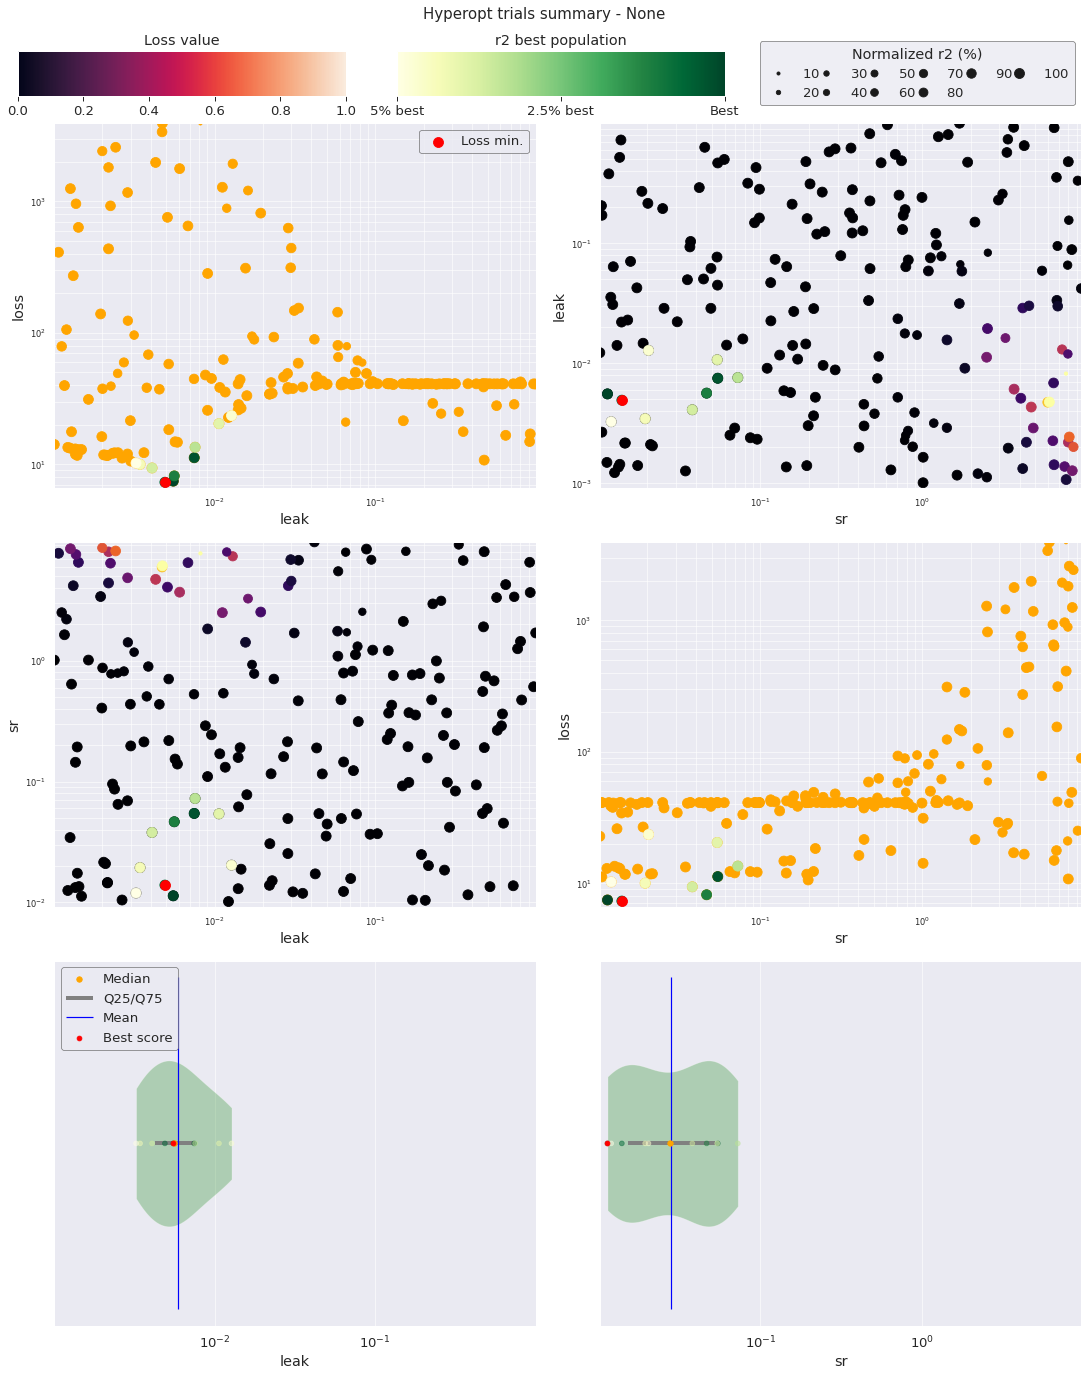

In [10]:
fig = plot_hyperopt_report(hyperopt_config["exp"], ("leak", "sr"), metric="r2")

In this plot, each orange dot represents an approximation of the loss, as a function of one parameter at a time. The red dot is the lowest loss, and the green dots are the bests values for the chosen metric, here the $R^2$ score. The other scatter plots show the interaction of the parameters with themselves and the loss.
The violin plots below help giving an overview of the parameter distribution of the bests results.

## Next task: make a forecast for COVID data

Data can be found at www.data.gouv.fr.

We want to make a forecast of 4 indicators giving insight on the spread of the COVID epidemic in France.

In [12]:
data = requests.get("https://www.data.gouv.fr/fr/datasets/r/d2671c6c-c0eb-4e12-b69a-8e8f87fc224c").json()
df = pd.DataFrame(data)

df = df.fillna(0)
df["date"] = pd.to_datetime(df["date"]) 
df = df.sort_values(by="date").reset_index(drop=True)

feat_names = ['reanimation', 'hospitalises',  # hostpitalizations features names
              'nouvellesHospitalisations', 'nouvellesReanimations']  # intensive care features names

df.head()

,casConfirmes,deces,date,gueris,reanimation,testsRealises,testsPositifs,hospitalises,nouvellesHospitalisations,nouvellesReanimations,...,stockNombreTotalDoses,stockNombreDosesPfizer,stockNombreDosesModerna,livraisonsCumulNombreTotalDoses,livraisonsCumulNombreDosesPfizer,livraisonsCumulNombreDosesModerna,totalPrisesRendezVousSemaine,prisesRendezVousSemaineRang1,prisesRendezVousSemaineRang2,stockEhpadNombreDosesPfizer
0,191,3,2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,212,4,2020-03-03,12.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,285,4,2020-03-04,0.0,15.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,423,7,2020-03-05,0.0,23.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,613,9,2020-03-06,0.0,39.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
def plot_dataframe(features, df):
    matplotlib.rc_file_defaults()
    plt.figure(figsize=(15, 5))
    for i, feat in enumerate(feat_names):
        plt.plot(df[feat], label=feat)
    ticks = [0, 50, 100, 150, 200, 250]
    plt.xticks(ticks, [df["date"].loc[i].date() for i in ticks], rotation=45)
    plt.ylabel("Features")
    plt.legend(); plt.show();

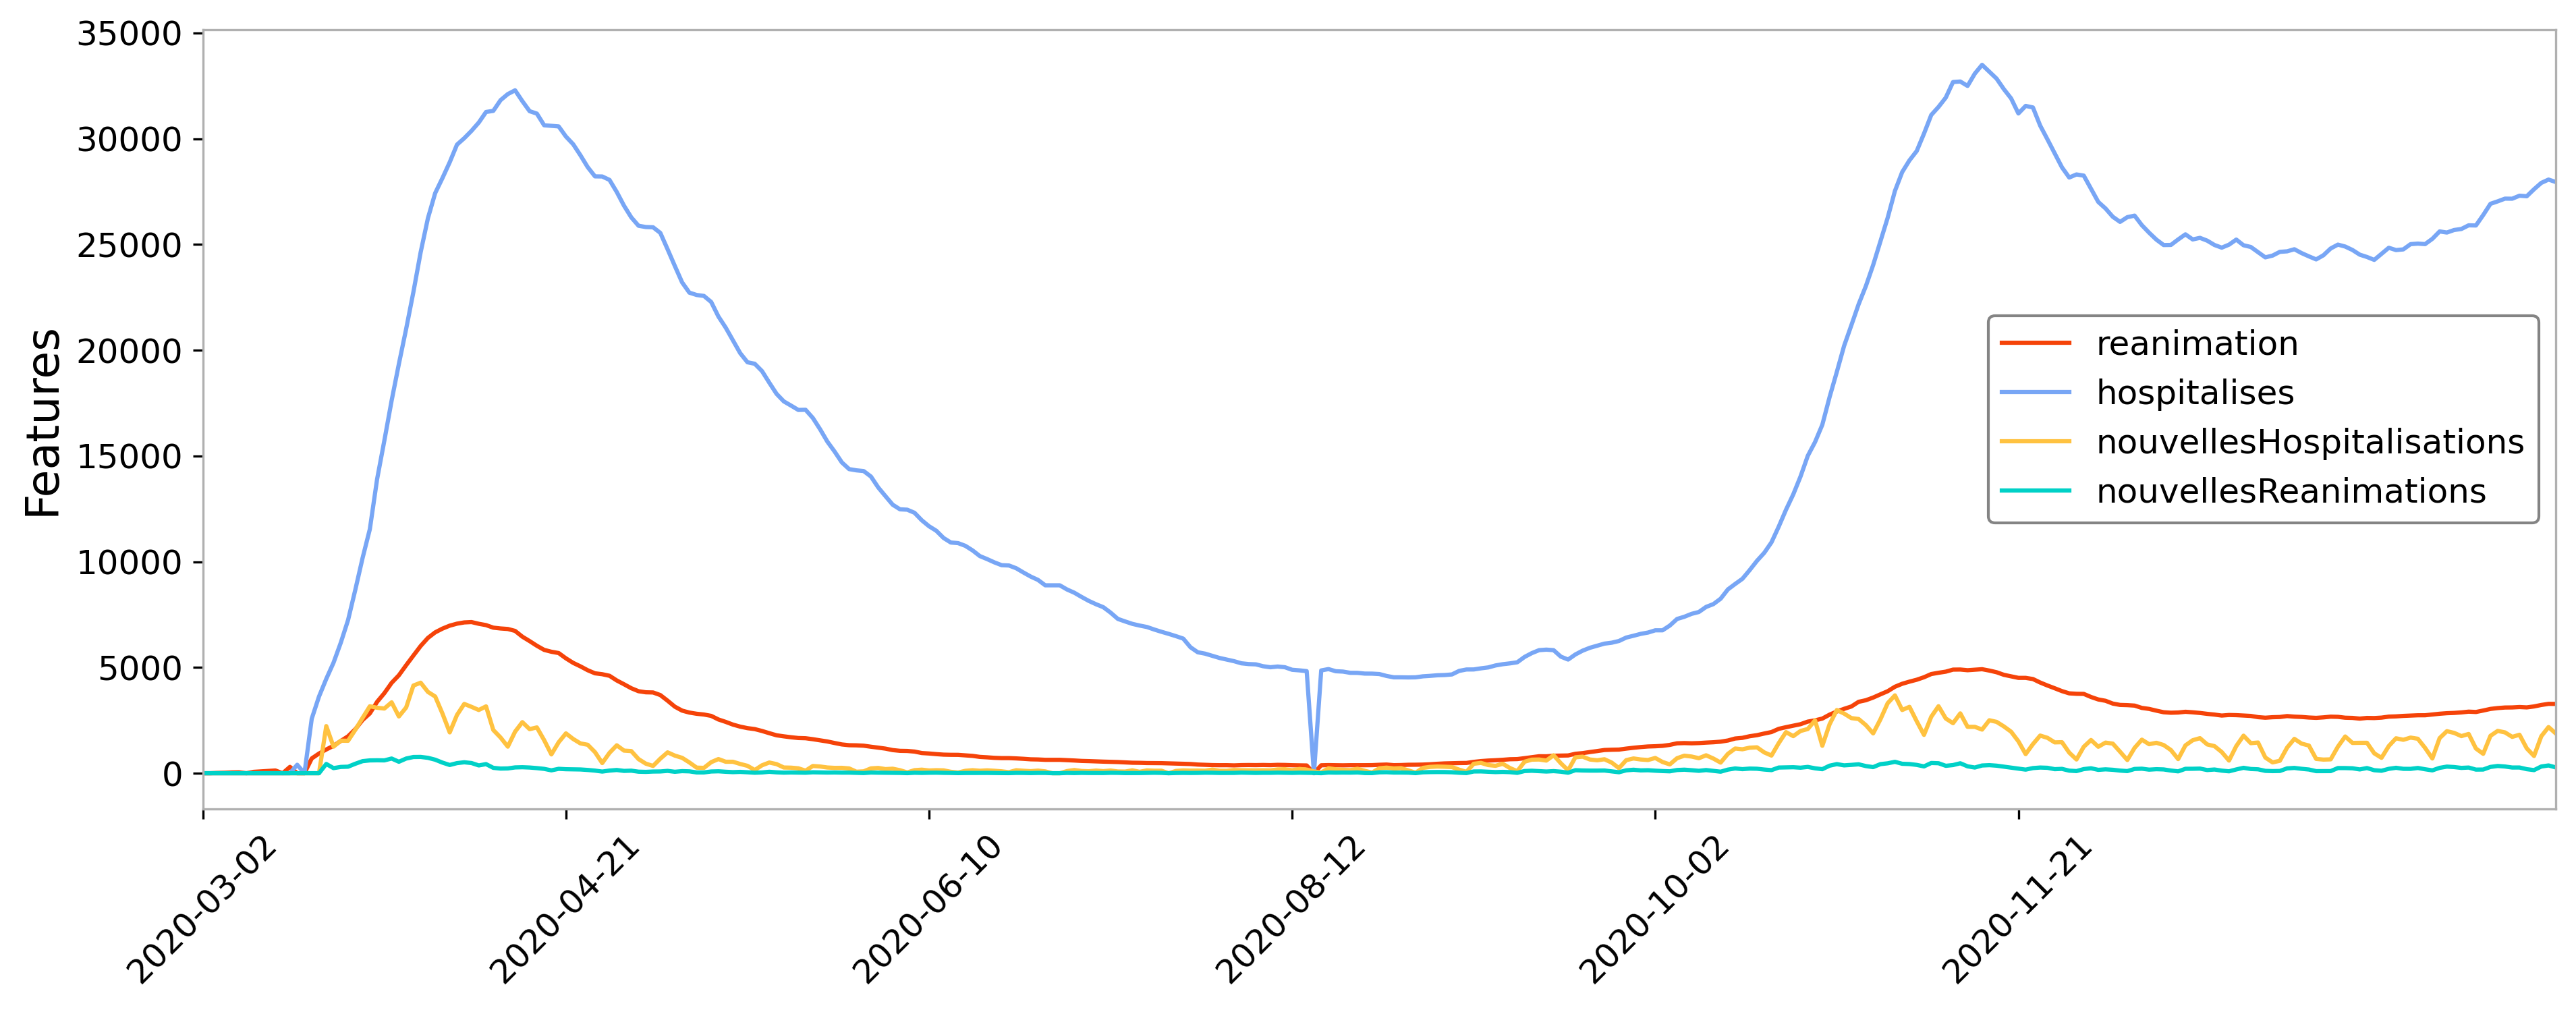

In [14]:
plot_dataframe(feat_names, df)

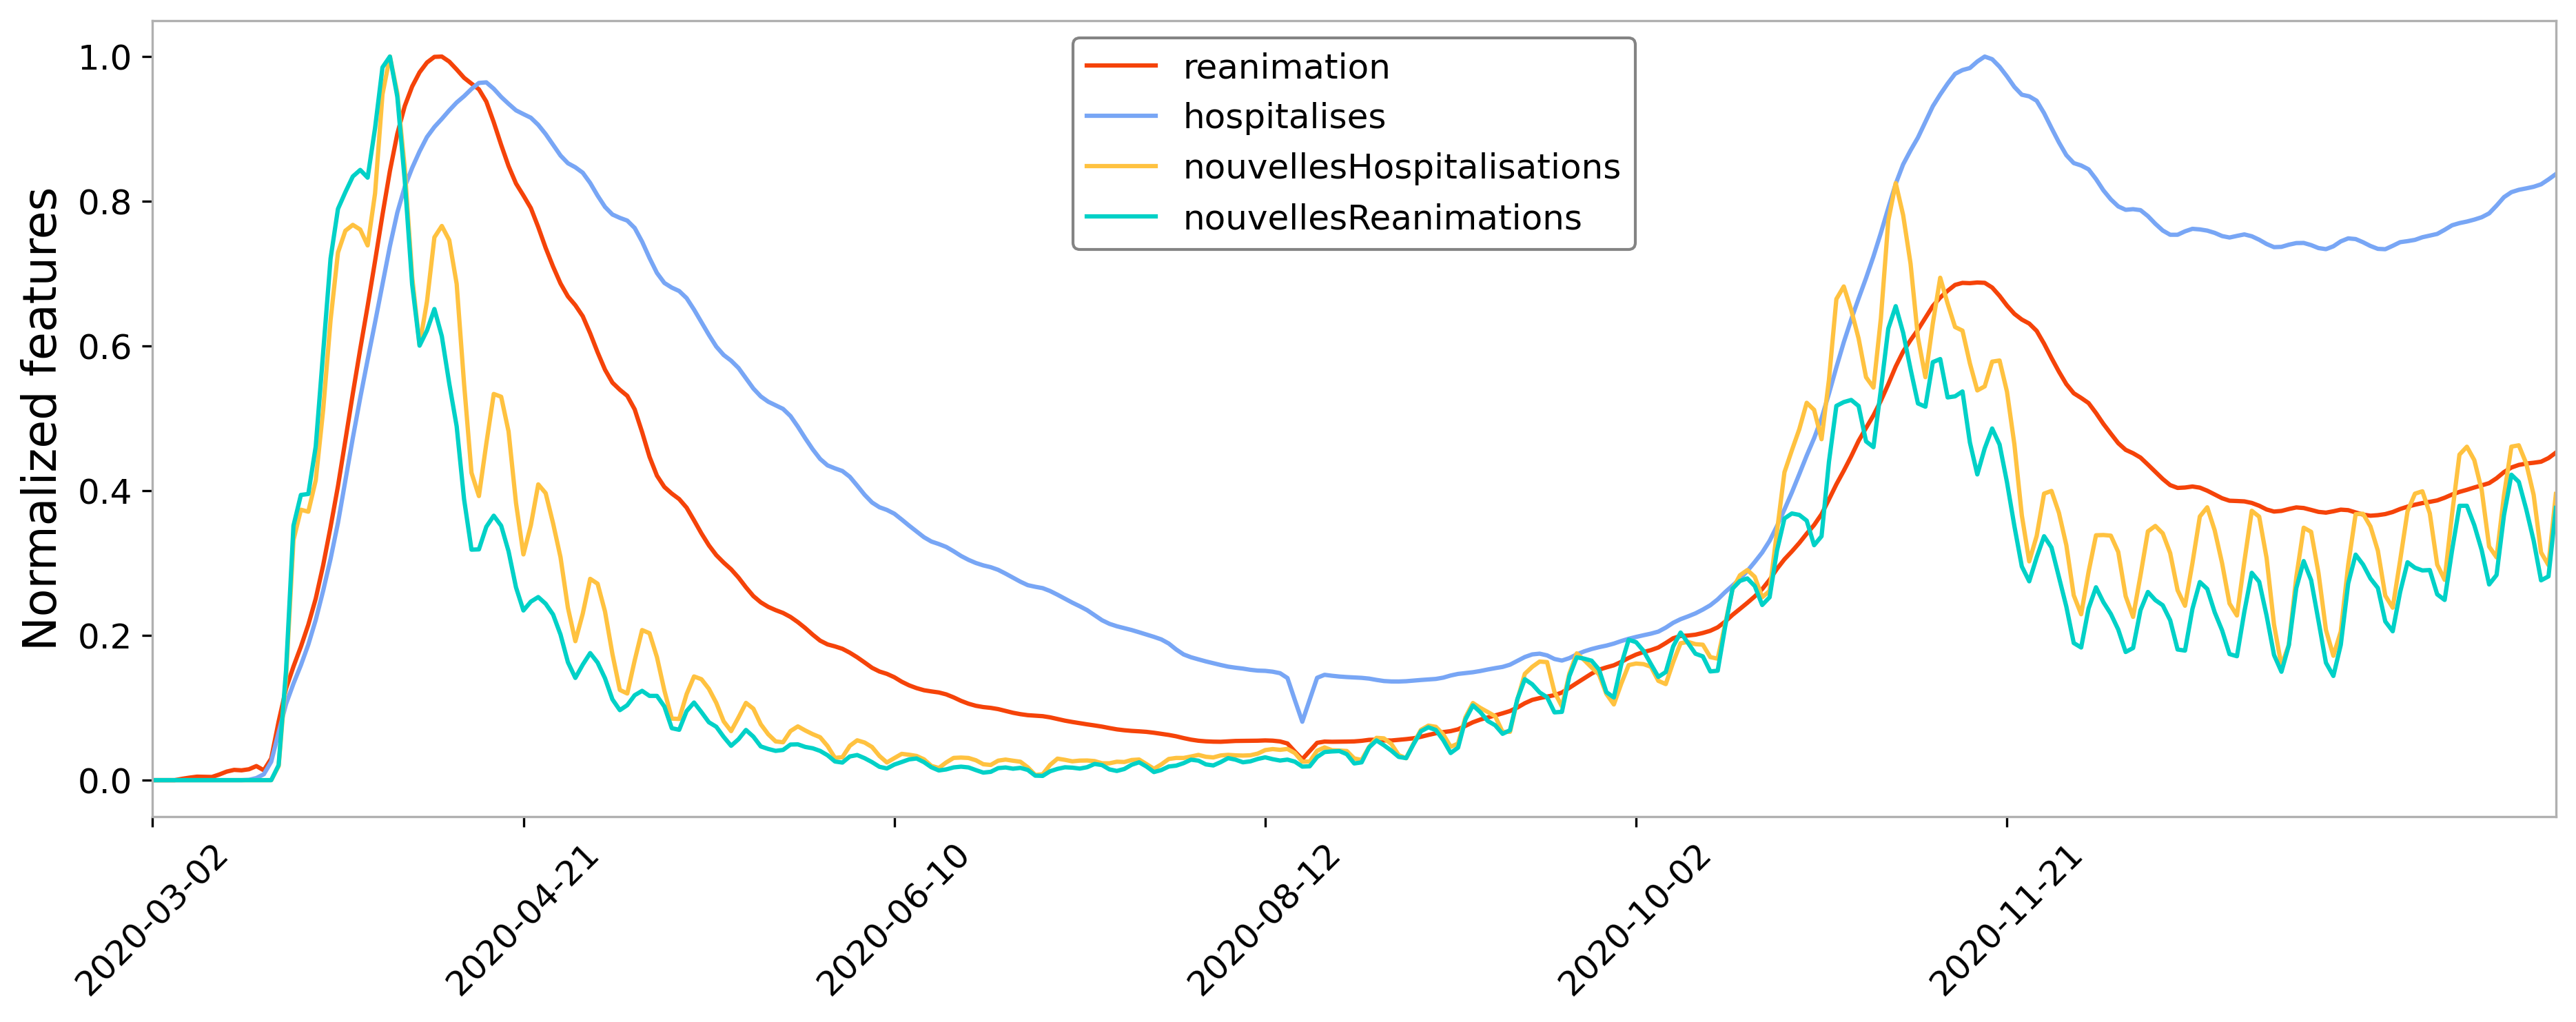

In [15]:
X_roll = np.array([df[f].rolling(5, win_type="hamming").mean().fillna(0).values for f in feat_names]).T
X = (X_roll - X_roll.min(axis=0)) / (X_roll.max(axis=0) - X_roll.min(axis=0))

matplotlib.rc_file_defaults()
plt.figure(figsize=(15, 5))
for i, feat in enumerate(feat_names):
    plt.plot(X[:, i], label=feat)
ticks = [0, 50, 100, 150, 200, 250]
plt.xticks(ticks, [df["date"].loc[i].date() for i in ticks], rotation=45)
plt.ylabel("Normalized features")
plt.legend(); plt.show();

In [16]:
test_len = 200

X_train = X[:-test_len-1]
y_train = X[1: -test_len]

X_test = X[-test_len-1:-1]
y_test = X[-test_len:]


dataset = (X_train, y_train), (X_test, y_test)

### Run the search

We define the task the same way as before. We will reuse the hyperopt configuration and the objective function used for double-scroll attractor generation task. Feel free to tune the hyperparameter search your own way.

In [17]:
experimentation_no = 0

In [18]:
covid_config = {
    "exp": f"{experimentation_no}-hyperopt-covid", # the experimentation name
    "hp_max_evals": 500,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 300
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-6 and 10
        "leak": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["choice", 0.9],           # the input scaling is fixed
        "ridge": ["choice", 1e-7],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


with open(f"{covid_config['exp']}.config.json", "w+") as f:
    json.dump(covid_config, f)

In [26]:
def covid_objective(dataset, config, *, iss, N, sr, leak, ridge, seed):
        
    # unpack train and test data, with target values.
    
    train_data, test_data = dataset
    
    X_train, y_train = train_data
    X_test, y_test = test_data


    nb_features = X_train.shape[1]

    instances = config["instances_per_trial"]

    variable_seed = seed # the seed will be changed across the instances, always in the 
                         # way across the trials, to be sure there is no bias in the results
                         # due to initialization.
    
    losses = []; r2 = [];
    for n in range(instances):
        # builds an ESN given the input parameters
        W = mat_gen.fast_spectral_initialization(N=N, sr=sr,
                                                 seed=variable_seed)

        Win = mat_gen.generate_input_weights(nbr_neuron=N, dim_input=nb_features, 
                                             input_bias=True, input_scaling=iss,
                                             seed=variable_seed+1)


        reservoir = ESN(lr=leak, W=W, Win=Win, input_bias=True, ridge=ridge)


        # train and test the model
        reservoir.train([X_train], [y_train], verbose=False)

        warming_inputs = X_train
        generations = len(X_test)
        outputs, _, _, _ = reservoir.generate(generations, warming_inputs=warming_inputs, verbose=False)

        losses.append(rmse(outputs[0], y_test))
        r2.append(r2_score(outputs[0], y_test))
        
        variable_seed += 1 # shift the seed between instances

    # returns a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2)}

In [57]:
train_length = len(df) - 31

X_train = X[:train_length]
y_train = X[1: train_length+1]

X_test = X[train_length:-1]
y_test = X[train_length+1:]


covid_dataset = (X_train, y_train), (X_test, y_test)

In [48]:
experimentation_no += 1

# run the random search
best = research(covid_objective, covid_dataset, f"{covid_config['exp']}.config.json", ".")

100%|██████████| 500/500 [05:54<00:00,  1.41trial/s, best loss: 5.392215696113077] 


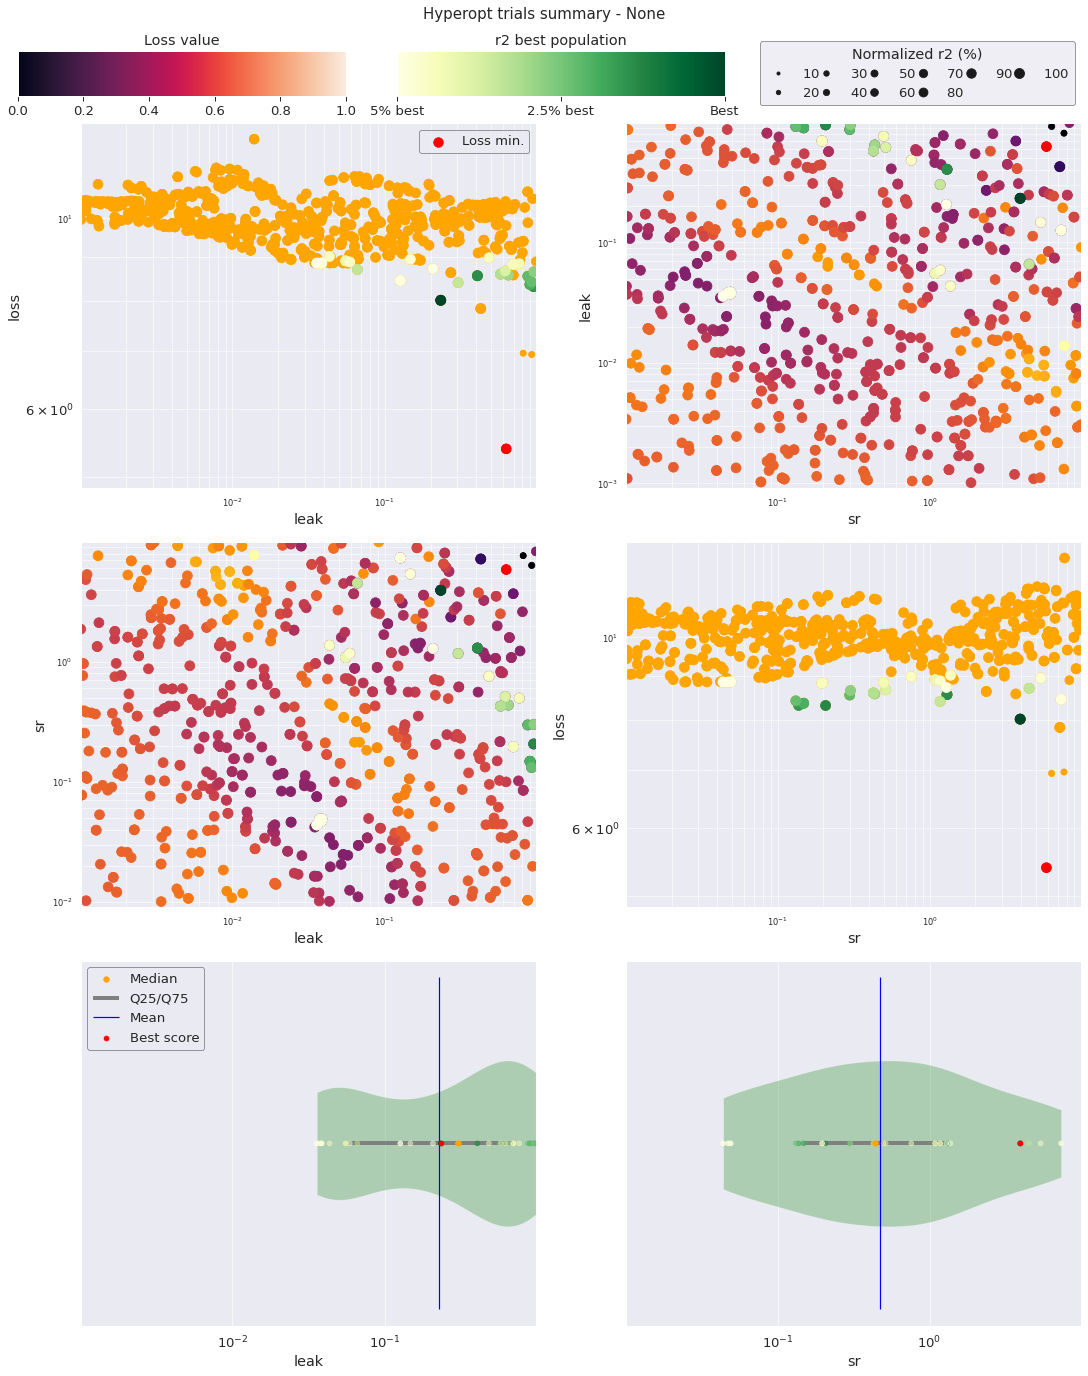

In [28]:
fig = plot_hyperopt_report(covid_config["exp"], ("leak", "sr"), metric="r2")

In [107]:
units = 1000
leak_rate = 0.23
spectral_radius = 3.95
iss = 0.9
density = 0.1
input_connectivity = 0.1
regularization = 1e-7
seed = 1234

W = mat_gen.fast_spectral_initialization(units, spectral_radius=spectral_radius,
                              proba=density, seed=seed)

Win = mat_gen.generate_input_weights(units, 4, input_scaling=iss, 
                                     proba=input_connectivity, input_bias=True,
                                     seed=seed+1)

reservoir = ESN(leak_rate, W, Win, ridge=regularization)

In [114]:
states = reservoir.train([X_train], [y_train], verbose=True, wash_nr_time_step=0)

y_pred, states = reservoir.generate(X_test.shape[0], init_inputs=X_train)

Computing states: 100%|██████████| 1/1 [00:00<00:00, 1105.80it/s]

Training on 1 inputs (243 steps)-- wash: 0 steps
Linear regression...
Linear regression done! (in 0.13899874687194824 sec)


In [115]:
def plot_results():
    matplotlib.rc_file_defaults()
    fig = plt.figure(figsize=(15, 5))
    color = matplotlib.rcParams['axes.prop_cycle'][:len(feat_names)]
    
    ax1 = fig.add_subplot(111)
    ax1.set_prop_cycle(color)
    ax1.set_title(f"{len(y_test)} days forecast of Covid hospitalization indicators")
    ax1.plot(y_pred)
    ax1.plot(y_test, linestyle="--")
    ax1.plot([],[], color="black", label="Generated")
    ax1.plot([],[], linestyle="--", color="black", label="Real")
    ax1.plot([],[],' ', label=f"$R^2={round(r2_score(y_test, y_pred), 4)}$")
    ax1.plot([],[],' ', label=f"$RMSE={round(rmse(y_test, y_pred), 4)}$")
    ax1.set_ylabel("Normalized indicator")
    ticks = [i for i in range(0, len(y_test), 5)]
    ax1.set_xticks(ticks)
    ax1.set_xticklabels([df["date"].loc[len(y_train) + i].date() for i in ticks], rotation=45)
    ax1.legend()

    plt.show()

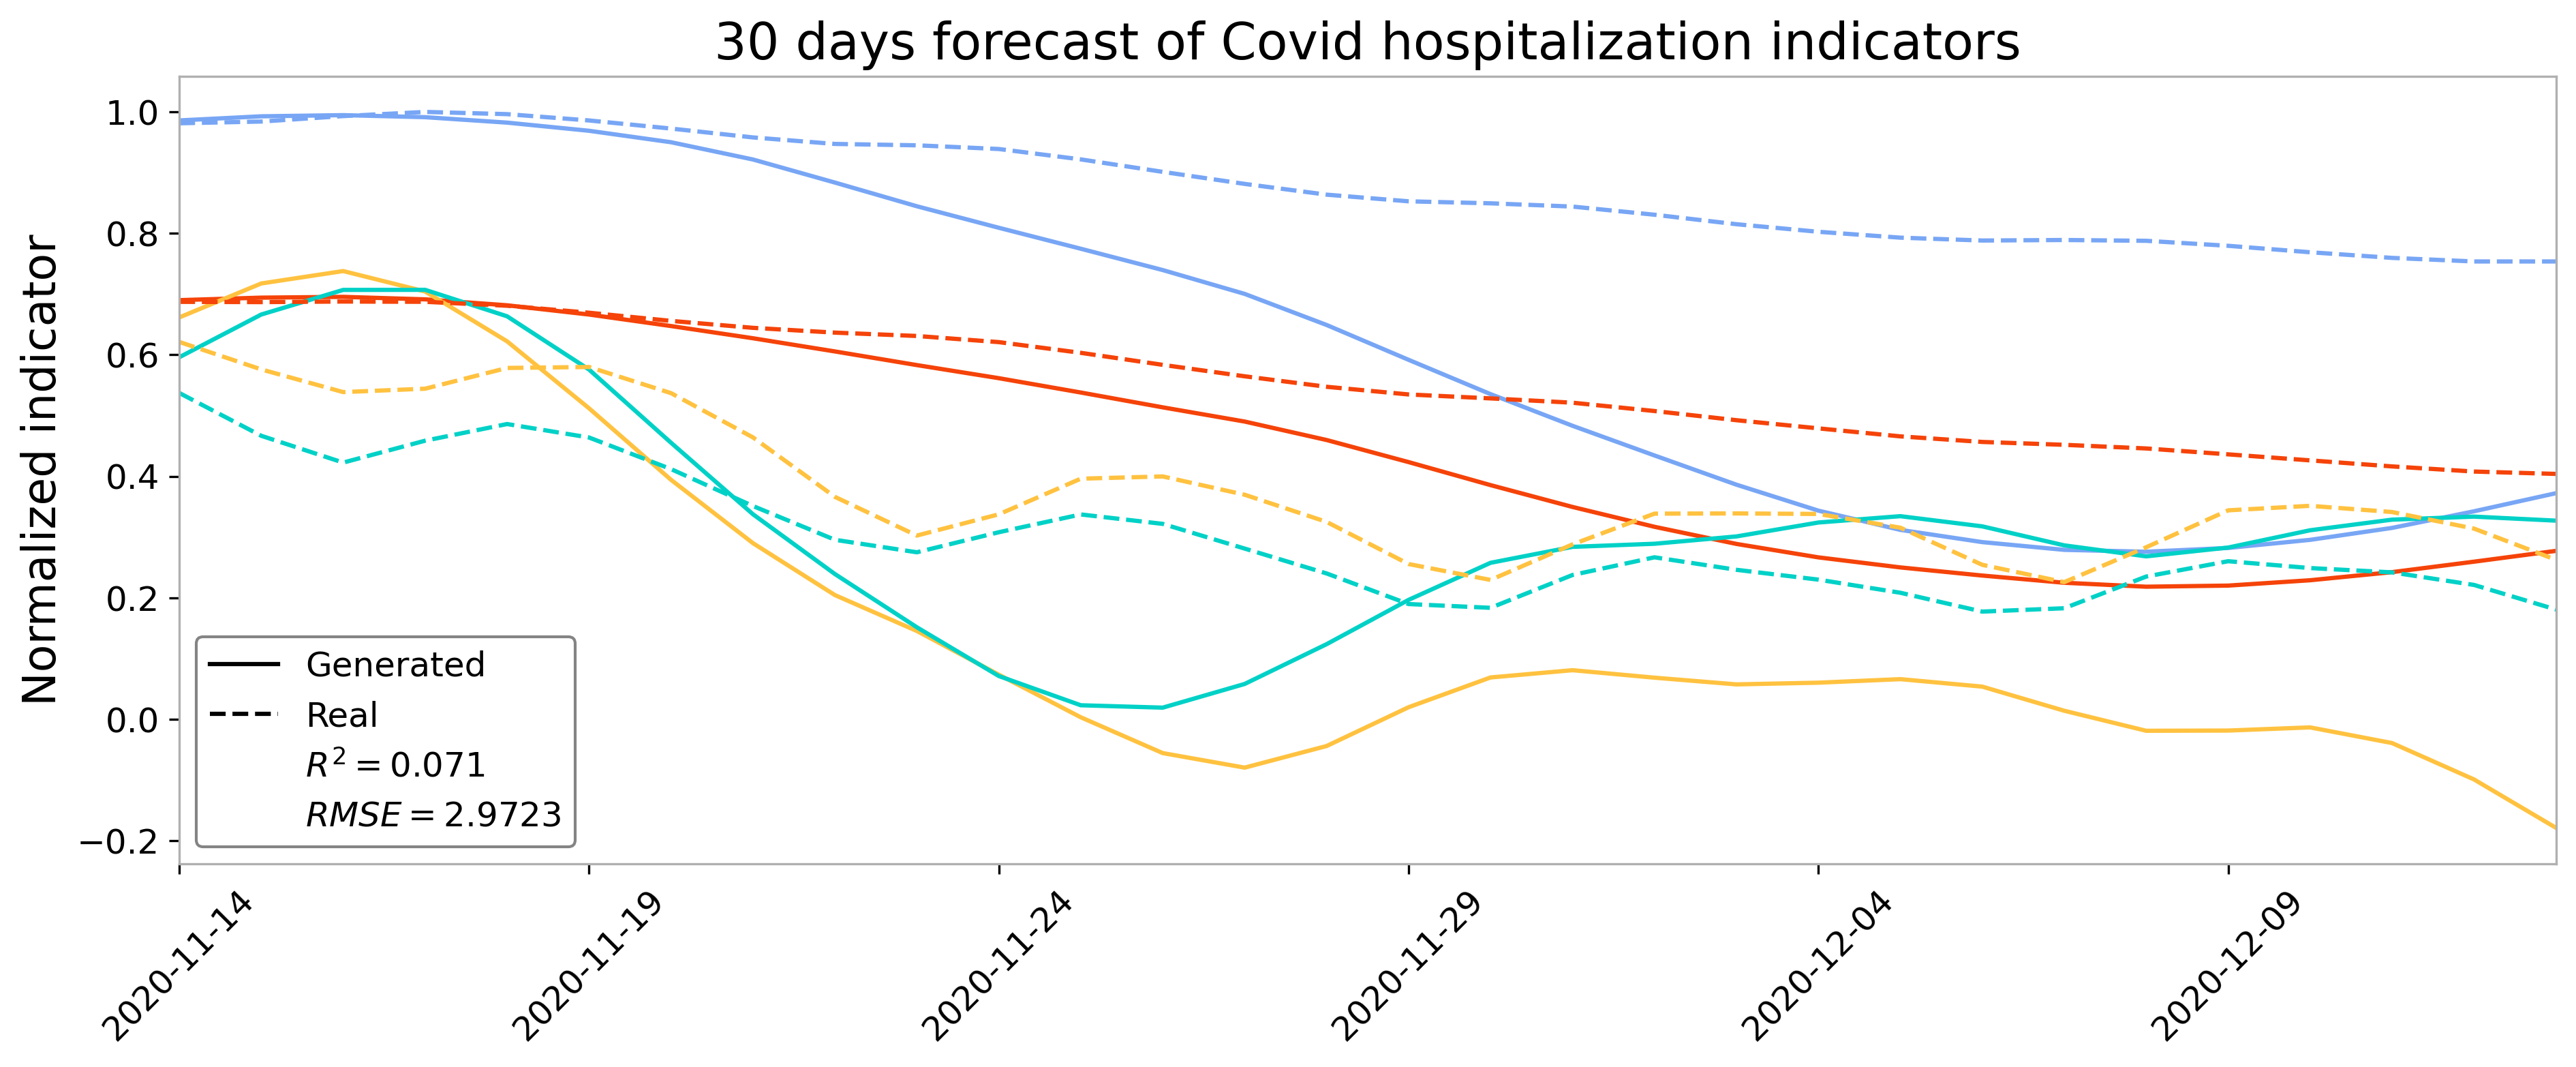

In [116]:
plot_results()